In [1]:
import torch
#import tenseal as ts
import pandas as pd
import random
from time import time

import numpy as np
import matplotlib.pyplot as plt

from torchmetrics.classification import BinaryAccuracy
accuracy = BinaryAccuracy()

import subprocess


In [2]:
n_parts = 2

# parameters
context = [None, 256, 512, 1024][2]
key = {None:"N/A",  256:"keys/def_80_256_1", 512:"keys/def_80_512_1", 1024:"keys/def_80_2014_1"}[context]
prec = 6
padd = int(np.log2(n_parts))
lower = -2.0
upper = 2.0

# target/release/add_vectors keys/def_80_512_1 6 4 0.0 1.0 2 2 0.5 0.3 0.7 0.4
print(key, prec, padd, lower, upper)

keys/def_80_512_1 6 1 -2.0 2.0


In [3]:
df = pd.read_csv("./data/myTenYearCHD_n1000.csv", index_col=0)
df.head()


,male,age,cigsPerDay,prevalentStroke,prevalentHyp,totChol,sysBP,heartRate,glucose,TenYearCHD
521,1.057131,-1.116420,0.894010,-0.083918,-0.792487,0.053780,-0.758911,-0.622219,-0.309160,1
737,1.057131,-1.116420,0.894010,-0.083918,-0.792487,-0.312693,-1.083813,-0.869361,-0.216819,1
740,-0.945011,-0.538324,-0.756825,-0.083918,-0.792487,-0.198170,0.012732,-0.045556,-0.247599,1
660,-0.945011,1.311586,-0.756825,-0.083918,1.260588,1.542577,2.368274,-0.045556,0.090987,1
411,1.057131,-0.653943,0.894010,-0.083918,1.260588,0.328635,0.906213,-0.951741,-0.432283,0


In [4]:
train_len = 800
part_len = train_len//n_parts

X_trn = torch.tensor(df.iloc[:train_len,:-1].values).float().split(part_len)
Y_trn = torch.tensor(df.iloc[:train_len,-1:].values).float().split(part_len)
X_tst = torch.tensor(df.iloc[train_len:,:-1].values).float()
Y_tst = torch.tensor(df.iloc[train_len:,-1:].values).float()

print(f"X_trn has size: {X_trn[0].shape}")
print(f"Y_trn has size: {Y_trn[0].shape}")
print(f"X_tst has size: {X_tst.shape}")
print(f"Y_tst has size: {Y_tst.shape}")


X_trn has size: torch.Size([400, 9])
Y_trn has size: torch.Size([400, 1])
X_tst has size: torch.Size([200, 9])
Y_tst has size: torch.Size([200, 1])


In [5]:
class LR(torch.nn.Module):

    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)
        
    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out


In [6]:
def addition_tree(parts):
    n = len(parts)
    if n==1:
        return parts[0]
    elif n%2==0:
        return addition_tree(parts[:n//2]) + addition_tree(parts[n//2:]) 
    else:
        print("Error: length must power of 2")
        return None
    
#addition_tree([1,2,3,4]), addition_tree(Y_trn).shape  
#addition_tree([model.weight() for model in models])   
#addition_tree([model.bias() for model in models])   


In [7]:
temp = [torch.tensor([[ 0.1343,  0.1045, -0.1228,  0.1349,  0.1253, -0.0090,  0.1801, -0.0008, 0.0048]]), 
        torch.tensor([[ 0.1287,  0.1348, -0.0748,  0.0556,  0.1216, -0.0075,  0.1372, -0.0091, 0.0661]])]

#temp = [torch.tensor([0.0944]), torch.tensor([0.0202])]

#!target/release/add_vectors keys/def_80_512_1 6 4 0.0 1.0 2 2 0.5 0.3 0.7 0.4

def tfhe_addition_tree(vecs):
    shape = vecs[0].shape
    flatten = [vec.flatten().numpy() for vec in vecs]
    n_vectors = len(flatten)
    m_entries = len(flatten[0])
    vectors = " ".join(["%f"%a for a in np.concatenate(flatten)])
    command = f"target/release/add_vectors {key} {prec} {padd} {lower} {upper} {n_vectors} {m_entries} {vectors}"
    #print(command)
    out = subprocess.getoutput(command).split("\n")[-1]
    #print(out)
    times, result = out.split(" [")
    #print(times)
    times = [float(a) for a in times.split(" ")]
    result = [float(a) for a in result[:-1].split(",")]
    result = torch.tensor(result).reshape(shape)
    return times, result

#tfhe_addition_tree(temp).shape, temp[0].shape
#tfhe_addition_tree(temp) - (temp[0]+temp[1])
tfhe_addition_tree(temp)


([201.0, 585.0, 219.0, 25.0],
 tensor([[ 0.2630,  0.2393, -0.1976,  0.1905,  0.2469, -0.0165,  0.3173, -0.0099,
           0.0709]]))

In [8]:
n_features = X_trn[0].shape[1]
n_epochs = 5

# use Binary Cross Entropy Loss
criterion = torch.nn.BCELoss()

def train_distr(context = None, verbose = False):
    wtimes = [0,0,0,0]
    btimes = [0,0,0,0]
    models = [LR(n_features) for i in range(n_parts)]
    optims = [torch.optim.SGD(model.parameters(), lr=1) for model in models]
    for i in range(n_epochs):
        # Each part takes a gradient step to modify params based on their data
        for j in range(n_parts):
            optims[j].zero_grad()
            out = models[j](X_trn[j])
            loss = criterion(out, Y_trn[j])
            if verbose:
                print(f"Epoch {i} loss for part {j}: {loss.data}")
            loss.backward()
            optims[j].step()
        weights = [model.state_dict()["lr.weight"]/n_parts for model in models]
        #print(weights[0]) # .tolist()[0])
        biases = [model.state_dict()["lr.bias"]/n_parts for model in models]
        #print(biases[0]) # .tolist()[0])
        if context is None:
            aggr_weight = addition_tree(weights)
            aggr_bias = addition_tree(biases)
        else:
            wtimes, aggr_weight = tfhe_addition_tree(weights)
            btimes, aggr_bias = tfhe_addition_tree(biases)
        state_dict = models[0].state_dict().copy()
        state_dict["lr.weight"] = aggr_weight
        state_dict["lr.bias"] = aggr_bias        
        # Aggregate params are shared with all parts who update their model
        for model in models:
            model.load_state_dict(state_dict.copy())
    return wtimes+btimes, models


## Distributed training with plain text aggregation

In [9]:
_, plain_models = train_distr()

for j, model in enumerate(plain_models):
    out = model(X_trn[j])
    loss = criterion(out, Y_trn[j])
    print(f"Epoch {n_epochs} loss for part {j}: {loss.data}")

plain_prediction = plain_models[0](X_tst)
plain_accuracy = accuracy(plain_prediction,Y_tst)
print(f"Plain model accuracy on test set: {plain_accuracy}")
    

Epoch 5 loss for part 0: 0.5920079350471497
Epoch 5 loss for part 1: 0.6061378121376038
Plain model accuracy on test set: 0.6949999928474426


## Distributed training with encypted aggregation

In [10]:
times, crypt_models = train_distr(context)

for j, model in enumerate(crypt_models):
    out = model(X_trn[j])
    loss = criterion(out, Y_trn[j])
    print(f"Epoch {n_epochs} loss for part {j}: {loss.data}")

crypt_prediction = crypt_models[0](X_tst)
crypt_accuracy = accuracy(crypt_prediction,Y_tst)
print(f"Plain model accuracy on test set: {crypt_accuracy}")
print(f"Times: {times}")


Epoch 5 loss for part 0: 0.5925970077514648
Epoch 5 loss for part 1: 0.6059553623199463
Plain model accuracy on test set: 0.6899999976158142
Times: [118.0, 490.0, 185.0, 21.0, 146.0, 67.0, 29.0, 4.0]


## Collect stats for training and evaluation

In [11]:
tst = []
N_rounds = 100

verbose = False

for i in range(N_rounds):
    row = []
    
    t0 = time()
    times, plain_models = train_distr(verbose=False)
    row.append(time()-t0)
    
    plain_prediction = plain_models[0](X_tst)
    plain_accuracy = accuracy(plain_prediction,Y_tst).tolist()
    row.append(plain_accuracy)
    
    t1 = time()
    times, crypt_models = train_distr(context,verbose=False)
    row.append(time()-t1)

    crypt_prediction = crypt_models[0](X_tst)
    crypt_accuracy = accuracy(crypt_prediction,Y_tst).tolist()
    row.append(crypt_accuracy)
    
    #row.append(times[0])
    row.append(times[1]+times[5])
    row.append(times[2]+times[6])
    row.append(times[3]+times[7])
    
    tst.append(row)
    if i%(N_rounds//10)==0 or i == N_rounds-1:
        print(f"Round {i+1} completed in {time()-t0}")

res = pd.DataFrame(tst, columns=["plain_time","plain_acc","crypt_time","crypt_acc",
                                                    "enc_time","add_time","dec_time"])
res

Round 1 completed in 0.08207535743713379
Round 11 completed in 0.0816030502319336
Round 21 completed in 0.08629798889160156
Round 31 completed in 0.08585476875305176
Round 41 completed in 0.08591532707214355
Round 51 completed in 0.08790874481201172
Round 61 completed in 0.08458375930786133
Round 71 completed in 0.0833742618560791
Round 81 completed in 0.08423829078674316
Round 91 completed in 0.0847320556640625
Round 100 completed in 0.08873319625854492


,plain_time,plain_acc,crypt_time,crypt_acc,enc_time,add_time,dec_time
0,0.007428,0.700,0.071962,0.710,701.0,257.0,27.0
1,0.010097,0.680,0.068126,0.680,643.0,246.0,29.0
2,0.009923,0.690,0.070154,0.670,653.0,247.0,29.0
3,0.010703,0.685,0.070354,0.685,650.0,242.0,29.0
4,0.008360,0.685,0.070784,0.695,659.0,243.0,28.0
...,...,...,...,...,...,...,...
95,0.012862,0.685,0.073200,0.695,648.0,242.0,29.0
96,0.008595,0.700,0.070193,0.665,672.0,215.0,25.0
97,0.012754,0.685,0.069910,0.680,649.0,245.0,29.0
98,0.012089,0.665,0.071514,0.695,647.0,239.0,29.0


In [12]:
tmp = res.describe()
tmp.to_csv(f"figs/stats_distr_tfhe_{context}_{n_parts}.csv")
tmp


,plain_time,plain_acc,crypt_time,crypt_acc,enc_time,add_time,dec_time
count,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.00000
mean,0.010043,0.686850,0.070765,0.688450,645.08000,238.950000,28.42000
std,0.001214,0.009284,0.001253,0.010581,42.20505,19.718921,1.88122
min,0.007360,0.665000,0.068126,0.665000,487.00000,179.000000,22.00000
25%,0.009179,0.680000,0.070180,0.680000,647.00000,231.750000,29.00000
50%,0.010364,0.690000,0.070572,0.690000,651.00000,242.000000,29.00000
75%,0.010585,0.695000,0.071220,0.695000,658.00000,246.000000,29.00000
max,0.014673,0.705000,0.078701,0.715000,720.00000,300.000000,37.00000


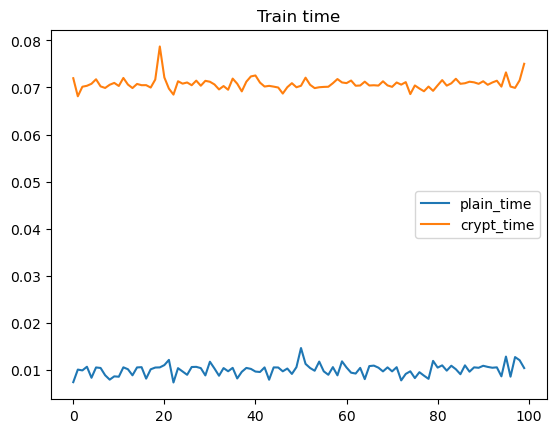

In [13]:
res.iloc[:,[0,2]].plot()
plt.legend()
plt.title("Train time")
plt.savefig(f"figs/traintime_distr_tfhe_{context}_{n_parts}.png")
plt.show()


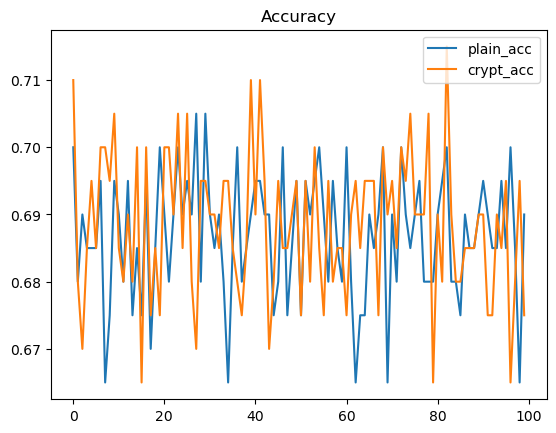

In [14]:
res.iloc[:,[1,3]].plot()
plt.legend()
plt.title("Accuracy")
plt.savefig(f"figs/accuracy_distr_tfhe_{context}_{n_parts}.png")
plt.show()


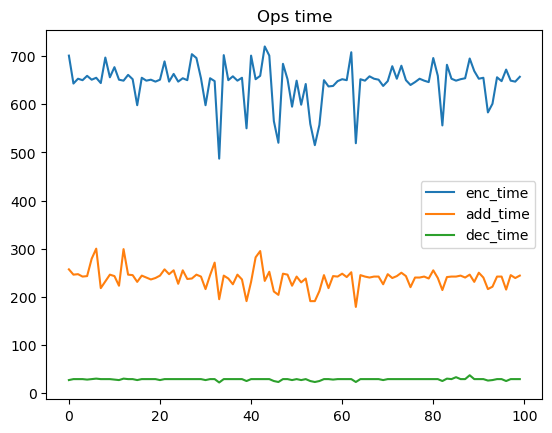

In [15]:
res.iloc[:,4:].plot()
plt.legend()
plt.title("Ops time")
plt.savefig(f"figs/ops_time_distr_tfhe_{context}_{n_parts}.png")
plt.show()


In [16]:
res.to_csv(f"figs/results_distr_tfhe_{context}_{n_parts}.csv")
